In [ ]:
import os
import sys
import pandas as pd
from prefect.blocks.system import Secret
from sqlalchemy import create_engine, select
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt


# Add the path using os to ensure the models can be imported
sys.path.append(os.path.dirname(os.path.abspath("")))

from models import ProviderAssetOrder, Asset

In [7]:
postgresql_password: str = (await Secret.load("postgresql-password")).get()
host = "db-postgresql-lon1-65351-do-user-18535103-0.m.db.ondigitalocean.com"
port = 25060
database = "defaultdb"
user = "doadmin"
url = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user=user,
    password=postgresql_password,
    host=host,
    port=port,
    database=database,
)

In [8]:
engine = create_engine(url, connect_args={"sslmode": "require"})

In [9]:
from sqlalchemy.orm import aliased
from models import Provider

# Create aliases for Asset to use in multiple joins
FromAsset = aliased(Asset)
ToAsset = aliased(Asset)

# Create the query
with Session(engine) as session:
    stmt = (
        select(
            ProviderAssetOrder.id,
            ProviderAssetOrder.timestamp,
            ProviderAssetOrder.price,
            ProviderAssetOrder.volume,
            FromAsset.name.label("from_asset_name"),
            ToAsset.name.label("to_asset_name"),
            Provider.name.label("provider_name"),
        )
        .join(FromAsset, ProviderAssetOrder.from_asset_id == FromAsset.id)
        .join(ToAsset, ProviderAssetOrder.to_asset_id == ToAsset.id)
        .join(Provider, ProviderAssetOrder.provider_id == Provider.id)
    )

    result_df = pd.read_sql(stmt, session.bind)

result_df

,id,timestamp,price,volume,from_asset_name,to_asset_name,provider_name
0,174570,2025-06-18 18:53:54,103010.0,0.002,USD,BTC,Kraken
1,174571,2025-06-18 18:54:43,102901.7,0.010,USD,BTC,Kraken
2,174572,2025-06-18 18:55:00,102879.0,0.009,USD,BTC,Kraken
3,174573,2025-06-18 18:56:06,103263.3,0.001,USD,BTC,Kraken
4,174574,2025-06-18 18:56:16,103048.5,0.001,USD,BTC,Kraken
...,...,...,...,...,...,...,...
104407,203880,2025-06-18 20:23:40,104490.1,0.005,BTC,USD,Kraken
104408,203881,2025-06-18 20:23:40,104490.2,0.005,BTC,USD,Kraken
104409,203882,2025-06-18 20:23:40,103137.3,0.003,USD,BTC,Kraken
104410,203883,2025-06-18 20:23:40,104111.9,0.052,USD,BTC,Kraken


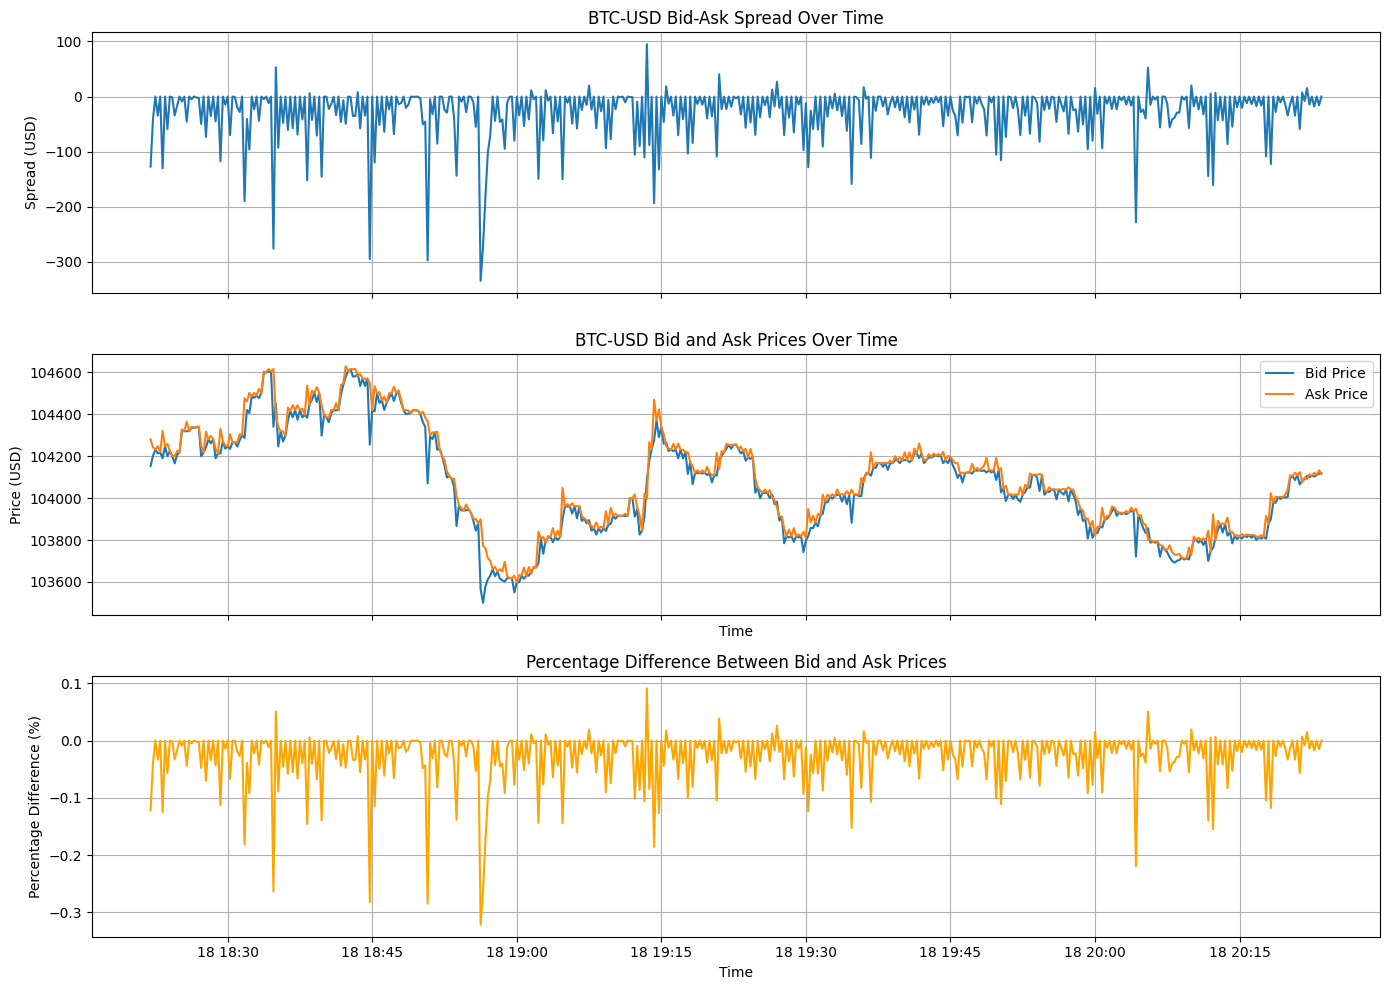

In [ ]:
# Filter for BTC-USD pairs only
btc_usd_df = result_df[
    ((result_df["from_asset_name"] == "BTC") & (result_df["to_asset_name"] == "USD"))
    | ((result_df["from_asset_name"] == "USD") & (result_df["to_asset_name"] == "BTC"))
]

# Identify bid and ask orders
ask_df = btc_usd_df[btc_usd_df["from_asset_name"] == "BTC"]  # Selling BTC for USD (ask)
bid_df = btc_usd_df[btc_usd_df["from_asset_name"] == "USD"]  # Buying BTC with USD (bid)

# Resample data to get time-based aggregation (per minute)
bid_prices = bid_df.set_index("timestamp").resample("15s")["price"].max()
ask_prices = ask_df.set_index("timestamp").resample("15s")["price"].min()

# Calculate the spread
spread_df = pd.DataFrame({"bid": bid_prices, "ask": ask_prices})
spread_df["spread"] = spread_df["bid"] - spread_df["ask"]
spread_df = spread_df.dropna()

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot spread
ax1.plot(spread_df.index, spread_df["spread"])
ax1.set_title("BTC-USD Bid-Ask Spread Over Time")
ax1.set_ylabel("Spread (USD)")
ax1.grid(True)

# Plot bid and ask prices
ax2.plot(spread_df.index, spread_df["bid"], label="Bid Price")
ax2.plot(spread_df.index, spread_df["ask"], label="Ask Price")
ax2.set_title("BTC-USD Bid and Ask Prices Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Price (USD)")
ax2.legend()
ax2.grid(True)

# Plot percentage difference in ask price relative to bid price
spread_df["percentage_difference"] = (
    (spread_df["bid"] - spread_df["ask"]) / spread_df["ask"] * 100
)
ax3.plot(spread_df.index, spread_df["percentage_difference"], color="orange")
ax3.set_title("Percentage Difference Between Bid and Ask Prices")
ax3.set_xlabel("Time")
ax3.set_ylabel("Percentage Difference (%)")
ax3.grid(True)

plt.tight_layout()
plt.show()